## Bernoulli Example

#### Support Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
import seaborn as sns
sns.set_style("white")
sns.set(context='notebook',
        style='ticks',
        font_scale=1,
        rc={'axes.grid':True,
            'grid.color':'.9',
            'grid.linewidth':0.75})

import contextlib
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
import itertools
from scipy.stats import fisher_exact

import warnings
warnings.simplefilter('ignore', DeprecationWarning)

In [2]:
# support functions
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

#### Plot the analytically derived expected risk of the naive estimator

Given $n$ samples from $P_t = Bern(p)$ and $m$ samples from $P_o = Bern(q = p+\Delta)$, we define the naive estimator as follows.
$$ \hat p_{naive} = \frac{n \hat p + m \hat q}{n+m} $$
where $\hat p = \frac{1}{n} \sum_{i=1}^n x_i \; ; x_i \sim Bern(p)$ and $\hat q = \frac{1}{m} \sum_{j=1}^m x_j \; ; x_j \sim Bern(q=p+\Delta)$. 

In [143]:
def mse(p, delta, n, m):
    q = p + delta
    nom = n*p*(1-p) + m*q*(1-q) + m**2*(p-q)**2
    denom = (n+m)**2
    return nom/denom

Text(0.5, 1.0, 'Naive Estimator')

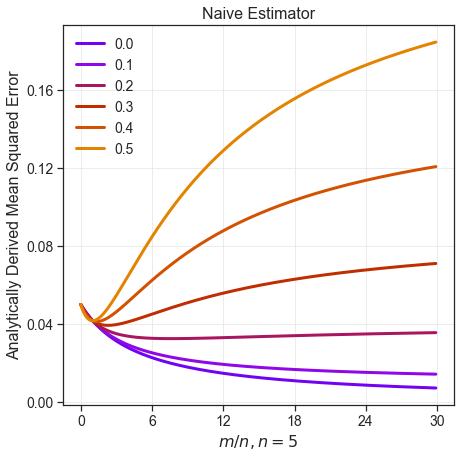

In [144]:
p = 0.5
delta_list = np.arange(0, 0.5+1e-3, 0.1)
n = 5
m_list = np.arange(0, 30, 0.1)

mse_list = []
for delta in delta_list:
    mse_delta = []
    for m in m_list:
        mse_delta.append(mse(p, delta, n, m))
    mse_list.append(mse_delta)
mse_list = np.array(mse_list)

fontsize = 16
labelsize = 14
fig, ax = plt.subplots(figsize=(7, 7))
cmap = [plt.cm.gnuplot(i) for i in np.linspace(0.2, 0.8, len(delta_list))]
for i, delta in enumerate(delta_list):
    ax.plot(m_list, mse_list[i], c=cmap[i], lw=3, label=str(np.round(delta, 2)))
ax.set_ylabel("Analytically Derived Mean Squared Error", fontsize=fontsize)
ax.set_xlabel(r"$m/n, n={}$".format(n), fontsize=fontsize)
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
ax.legend(fontsize=labelsize, frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.set_title("Naive Estimator", fontsize=fontsize)

#### Plot simulation-derived expected risk of the naive and Hodge's estimators

The Hodges estimator is defined as follows. 

Let $\Delta^\ast (n, m, p)$ be the threshold that determines the usage of $\hat p$ or $\hat p_{naive}$ in the Hodges estimator.
$$
\hat p_{hodges} = 
\begin{cases}
    \hat p, & \Delta > \Delta^\ast \\
    \frac{n \hat p + m \hat q}{n + m}, & \Delta < \Delta^\ast 
\end{cases}
$$

$\Delta^\ast (n, m, p)$ can be found by solving the following equation:
$$ MSE(\hat p_{naive}) = MSE(\hat p) $$

It can be shown that $\Delta^\ast (n, m, p)$ is given by the positive root of the following quadratic equation:
$$ \frac{m(m-1)}{(n+m)^2} \Delta^2 + \frac{m(1-2p)}{(n+m)^2} \Delta - \frac{mp(1-p)}{n(n+m)} = 0 $$


In [145]:
def get_ideal_criterion(p, q, n, m):
    delta = q - p
    coeff = [m*(m-1)/(n+m)**2, m*(1-2*p)/(n+m)**2, -m*p*(1-p)/(n*(n+m))]
    thresh = np.roots(coeff)
    thresh = thresh[thresh > 0]
    if len(thresh) == 0:
        return 0
    else:
        return delta - thresh[0]
    
def get_hodges_estimator(p_hat, q_hat, p_comb, p, q, plugin=False):
    if m != 0:
        if plugin:
            criterion = get_ideal_criterion(p_hat, q_hat, n, m)
        else:
            criterion = get_ideal_criterion(p, q, n, m)
    else:
        criterion = 1
    
    if criterion > 0:
        p_hodges = p_hat
    else:
        p_hodges = p_comb
    return p_hodges

def compute_squared_error(p, q, n, m):
    p_hat = np.random.binomial(n, p, 1)[0] / n
    if m == 0:
        q_hat = 0
    else:
        q_hat = np.random.binomial(m, q, 1)[0] / m
    
    p_comb = (n * p_hat + m * q_hat)/(n + m)
    p_hodges = get_hodges_estimator(p_hat, q_hat, p_comb, p, q, plugin=False)
    p_hodges_plugin = get_hodges_estimator(p_hat, q_hat, p_comb, p, q, plugin=True)

    se_comb = (p_comb - p)**2
    se_hodges = (p_hodges - p)**2
    se_hodges_plugin = (p_hodges_plugin - p)**2

    return se_comb, se_hodges, se_hodges_plugin

In [146]:
p = 0.5
delta_list = np.arange(0, 0.5+1e-3, 0.1)
n = 5
m_list = np.arange(0, 30, 2)
reps = 10000

hodges_list = []
hodgesp_list = []
comb_list = []

for delta in delta_list: 
    q = p + delta
    hodges_mse_list = []
    hodgesp_mse_list = []
    comb_mse_list = []
    
    for m in m_list: 
        q = p + delta

        f = lambda : compute_squared_error(p, q, n, m)

        with tqdm_joblib(tqdm(desc="Compute Acc", total=reps)) as progress_bar:
            ses = np.array(Parallel(n_jobs=-1)(delayed(f)() for i in range(reps)))
        
        mses = np.mean(ses, axis=0)
        comb_mse_list.append(mses[0])
        hodges_mse_list.append(mses[1])
        hodgesp_mse_list.append(mses[2])
        
    hodges_list.append(hodges_mse_list)
    comb_list.append(comb_mse_list)
    hodgesp_list.append(hodgesp_mse_list)
    
hodges_list = np.array(hodges_list)   
hodgesp_list = np.array(hodgesp_list)
comb_list = np.array(comb_list)

Compute Acc: 100%|██████████| 10000/10000 [00:00<00:00, 37485.36it/s]


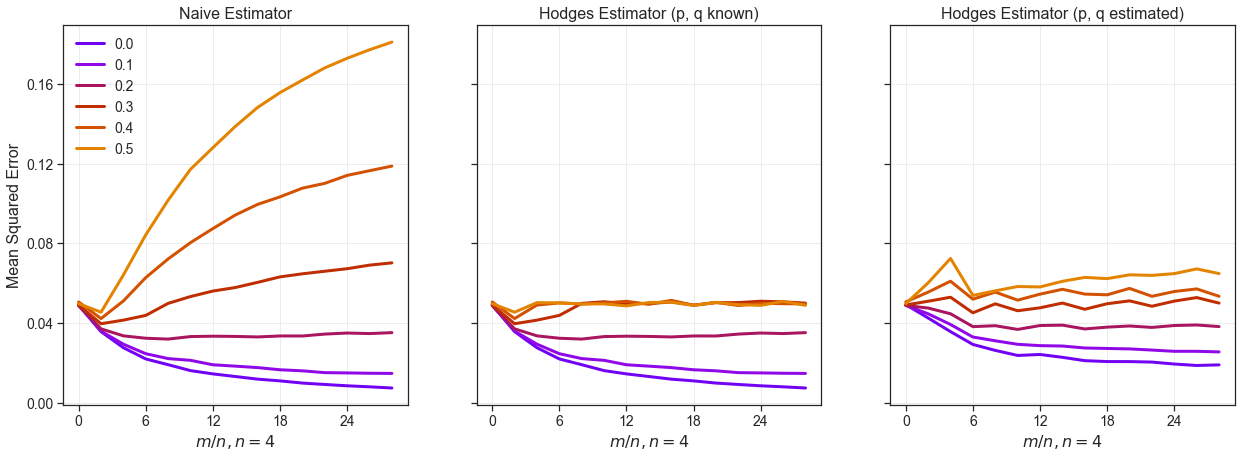

In [147]:
fontsize = 16
labelsize = 14
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
cmap = [plt.cm.gnuplot(i) for i in np.linspace(0.2, 0.8, len(delta_list))]
results = [comb_list, hodges_list, hodgesp_list]
titles = ["Naive Estimator", "Hodges Estimator (p, q known)", "Hodges Estimator (p, q estimated)"]
for j in range(3):
    ax = axes[j]
    for i, delta in enumerate(delta_list):
        ax.plot(m_list, results[j][i], c=cmap[i], lw=3, label=str(np.round(delta, 2)))
    ax.set_ylabel("Mean Squared Error", fontsize=fontsize)
    ax.set_xlabel(r"$m/n, n=4$", fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
    ax.legend(fontsize=labelsize, frameon=False)
    ax.xaxis.set_major_locator(MaxNLocator(6))
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.set_title(titles[j], fontsize=fontsize)

    if j == 0:
        ylim = ax.get_ylim()
    else:
        ax.set_ylim(*ylim)
        ax.set_ylabel("")
        ax.set_yticklabels("")
        ax.get_legend().remove()


### Plot the analytically derived expected risk of optimally weighted wstimator

The weighted estimator is defined as below.
$$ \hat p_{weighted} = \alpha^\ast \hat p + (1-\alpha^\ast) \hat q $$
where
$$ \alpha^\ast = \argmin_{\alpha} MSE(\alpha \hat p + (1-\alpha) \hat q) $$
For the Bernoulli example, the optimal weight is simply given by,
$$ \alpha^\ast = \frac{q(1-q)/m + (p-q)^2}{p(1-p)/n + q(1-q)/m + (p-q)^2} $$
Note that we can recover the naive estimator by setting the weight to $n/(n+m)$.

In [148]:
def weighted_mse(p, delta, n, m, weight):
    q = p + delta
    return weight**2 * p*(1-p)/n + (1-weight)**2 * (q*(1-q)/m + (p-q)**2)

def mse(p, delta, n, m):
    q = p + delta

    if m != 0:
        nom = q*(1-q)/m + (p-q)**2
        denom = p*(1-p)/n + q*(1-q)/m + (p-q)**2
        optimal_weight = nom/denom 
        optimal_mse = weighted_mse(p, delta, n, m, optimal_weight)

        naive_weight = n/(n+m)
        naive_mse = weighted_mse(p, delta, n, m, naive_weight)
    else:
        naive_mse = optimal_mse = p*(1-p)/n
        
    return naive_mse, optimal_mse

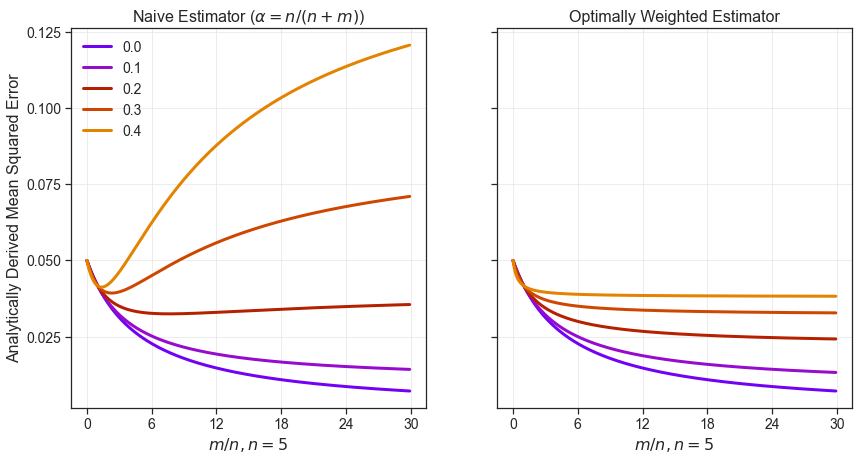

In [149]:
p = 0.5
delta_list = np.arange(0, 0.4+1e-3, 0.1)
n = 5
m_list = np.arange(0, 30, 0.1)

optimal_mse_list = []
naive_mse_list = []
for delta in delta_list:
    optimal_mse_delta = []
    naive_mse_delta = []
    for m in m_list:
        naive, optimal = mse(p, delta, n, m)
        optimal_mse_delta.append(optimal)
        naive_mse_delta.append(naive)
    optimal_mse_list.append(optimal_mse_delta)
    naive_mse_list.append(naive_mse_delta)
optimal_mse_list = np.array(optimal_mse_list)
naive_mse_list = np.array(naive_mse_list)

fontsize = 16
labelsize = 14
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
cmap = [plt.cm.gnuplot(i) for i in np.linspace(0.2, 0.8, len(delta_list))]
mse_list = [naive_mse_list, optimal_mse_list]
titles = [r"Naive Estimator ($\alpha = n/(n+m)$)", r"Optimally Weighted Estimator"]
for j in range(2):
    ax = axes[j]
    for i, delta in enumerate(delta_list):
        ax.plot(m_list, mse_list[j][i], c=cmap[i], lw=3, label=str(np.round(delta, 2)))
    ax.set_ylabel("Analytically Derived Mean Squared Error", fontsize=fontsize)
    ax.set_xlabel(r"$m/n, n={}$".format(n), fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
    ax.legend(fontsize=labelsize, frameon=False)
    ax.xaxis.set_major_locator(MaxNLocator(6))
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.set_title(titles[j], fontsize=fontsize)

    if j == 0:
        ylim = ax.get_ylim()
    else:
        ax.set_ylim(*ylim)
        ax.set_ylabel("")
        ax.set_yticklabels("")
        ax.get_legend().remove()

#### Plot the simulation derived expected risk of naive and weighted estimators

In [150]:
def get_weight(p, q, n, m):
    nom = q*(1-q)/m + (p-q)**2
    denom = p*(1-p)/n + q*(1-q)/m + (p-q)**2
    optimal_weight = (nom+1e-7)/(denom+1e-7) 
    return optimal_weight

def get_weighted_estimator(p_hat, q_hat, p, q, n, m, plugin=False):
    if plugin:
        weight = get_weight(p_hat, q_hat, n, m)
    else:
        weight = get_weight(p, q, n, m)
    return weight * p_hat + (1-weight) * q_hat

def compute_squared_error(p, q, n, m):
    p_hat = np.random.binomial(n, p, 1)[0] / n
    if m == 0:
        q_hat = 0
    else:
        q_hat = np.random.binomial(m, q, 1)[0] / m
    
    p_comb = (n * p_hat + m * q_hat)/(n + m)
    if m != 0:
        p_opt = get_weighted_estimator(p_hat, q_hat, p, q, n, m, plugin=False)
        p_opt_plugin = get_weighted_estimator(p_hat, q_hat, p, q, n, m, plugin=True)
    else:
        p_opt = p_opt_plugin = p_hat

    se_comb = (p_comb - p)**2
    se_opt = (p_opt - p)**2
    se_opt_plugin = (p_opt_plugin - p)**2

    return se_comb, se_opt, se_opt_plugin

In [151]:
p = 0.5
delta_list = np.arange(0, 0.5+1e-3, 0.1)
n = 5
m_list = np.arange(0, 30, 2)
reps = 10000

opt_list = []
optp_list = []
comb_list = []

for delta in delta_list: 
    q = p + delta
    opt_mse_list = []
    optp_mse_list = []
    comb_mse_list = []
    
    for m in m_list: 
        q = p + delta

        f = lambda : compute_squared_error(p, q, n, m)

        with tqdm_joblib(tqdm(desc="Compute Acc", total=reps)) as progress_bar:
            ses = np.array(Parallel(n_jobs=-1)(delayed(f)() for i in range(reps)))
        
        mses = np.mean(ses, axis=0)
        comb_mse_list.append(mses[0])
        opt_mse_list.append(mses[1])
        optp_mse_list.append(mses[2])
        
    opt_list.append(opt_mse_list)
    comb_list.append(comb_mse_list)
    optp_list.append(optp_mse_list)
    
opt_list = np.array(opt_list)   
optp_list = np.array(optp_list)
comb_list = np.array(comb_list)

Compute Acc: 100%|██████████| 10000/10000 [00:00<00:00, 49866.65it/s]


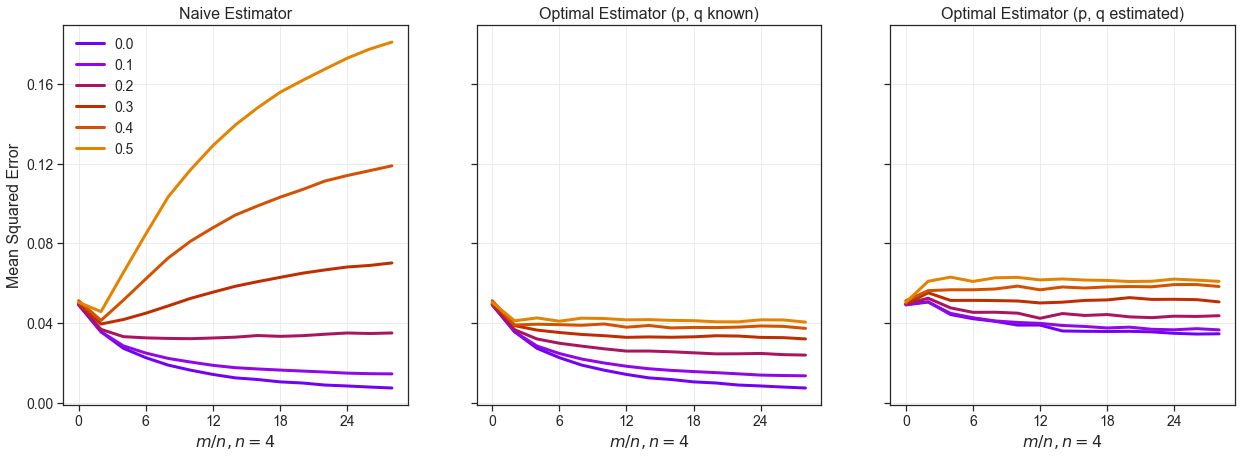

In [152]:
fontsize = 16
labelsize = 14
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
cmap = [plt.cm.gnuplot(i) for i in np.linspace(0.2, 0.8, len(delta_list))]
results = [comb_list, opt_list, optp_list]
titles = ["Naive Estimator", "Optimal Estimator (p, q known)", "Optimal Estimator (p, q estimated)"]
for j in range(3):
    ax = axes[j]
    for i, delta in enumerate(delta_list):
        ax.plot(m_list, results[j][i], c=cmap[i], lw=3, label=str(np.round(delta, 2)))
    ax.set_ylabel("Mean Squared Error", fontsize=fontsize)
    ax.set_xlabel(r"$m/n, n=4$", fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
    ax.legend(fontsize=labelsize, frameon=False)
    ax.xaxis.set_major_locator(MaxNLocator(6))
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.set_title(titles[j], fontsize=fontsize)

    if j == 0:
        ylim = ax.get_ylim()
    else:
        ax.set_ylim(*ylim)
        ax.set_ylabel("")
        ax.set_yticklabels("")
        ax.get_legend().remove()
